# Projection Methods
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TheRedElement/LStein/blob/main/demo/projection_methods.ipynb)

If you run this notebook in [google colab](https://colab.google/), you should not need to install anything else.
You might, however, need to restart your session to have the required versions of [matplotlib](https://matplotlib.org/), [numpy](https://numpy.org/), [Plotly](https://plotly.com/python/) ready.

In [ ]:
#in case you are in colab
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install git+https://github.com/TheRedElement/LStein.git

In [172]:
#%%imports
import importlib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from lstein import (
    utils as lsu,
    makedata as md
)
from lstein import lstein
importlib.reload(lstein)


<module 'lstein.lstein' from '/home/lukas/github/LStein/src/lstein/lstein.py'>

### `y_projection_method`

Depending on which method you use, different behaviors are to be expected.
Options are the following:

* `"theta"`
    * method:
        1. transform original series into $\theta$-space (polar coordinates)
        2. apply rescaling to project data into respective panel
        3. transform back into $y$-space (cartesian coordinates) for plotting
    * behavior:
        * distortion in x-direction
            * note the asymmetry of the wave-mountains and -valleys
        * accurate representation in y-direction
        * goes haywire for large x-values due to computation of $\tan$ and $arc\tan$ when converting between coordinate systems
* `"y"`
    * method:
        1. apply rescaling to project data into respective panel onto original data (cartesian coordinates)
        2. project to $\theta$-space (polar coordinates) to add the $\theta$-offset (for panel positioning)
        3. transform back into $y$-space (cartesian coordinates) for plotting
    * behavior:
        * no distortion in x-direction
            * wave-mountains and -valleys stay symmetrical
        * projections effects in y-direction
            * especially when overplotting several series
            * may lead to unexpected offsets between dataseries

### Get Data

In [173]:
#generate some data
raw, pro = md.simulate(opt="sin", theta=np.array([10,15,20,25,30]))
df_raw = pl.from_dict(raw)#.with_columns(pl.col("amplitude")+1e-3*pl.col("time")**2) #add quadratic trend to mae sure difference for y-inversion is visible
df_pro = pl.from_dict(pro)#.with_columns(pl.col("amplitude")+1e-3*pl.col("time")**2) #add quadratic trend to mae sure difference for y-inversion is visible
print(df_raw)

shape: (2_500, 5)
┌────────┬────────────┬───────────┬─────────────┬────────────┐
│ period ┆ time       ┆ amplitude ┆ amplitude_e ┆ processing │
│ ---    ┆ ---        ┆ ---       ┆ ---         ┆ ---        │
│ i64    ┆ f64        ┆ f64       ┆ f64         ┆ str        │
╞════════╪════════════╪═══════════╪═════════════╪════════════╡
│ 10     ┆ -49.699399 ┆ 0.586125  ┆ NaN         ┆ raw        │
│ 10     ┆ -49.398798 ┆ 0.709587  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.797595 ┆ 0.980439  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.797595 ┆ 0.570625  ┆ NaN         ┆ raw        │
│ 10     ┆ -48.496994 ┆ 0.236895  ┆ NaN         ┆ raw        │
│ …      ┆ …          ┆ …         ┆ …           ┆ …          │
│ 30     ┆ 98.797595  ┆ 0.938819  ┆ NaN         ┆ raw        │
│ 30     ┆ 99.098196  ┆ 1.162116  ┆ NaN         ┆ raw        │
│ 30     ┆ 99.398798  ┆ 0.898058  ┆ NaN         ┆ raw        │
│ 30     ┆ 99.699399  ┆ 0.981699  ┆ NaN         ┆ raw        │
│ 30     ┆ 100.0      ┆ 0.520469  ┆ N

In [174]:
#get dimensions

##raw
df_raw_p = df_raw.partition_by("period")    #partition by unique values in `"period"`
theta_raw = [df["period"].to_numpy()[0] for df in df_raw_p]    #only one value per series
x_raw = [df["time"].to_numpy() for df in df_raw_p]             #K values per series
y_raw = [df["amplitude"].to_numpy() for df in df_raw_p]        #K values per series

##processed
df_pro_p = df_pro.partition_by("period")    #partition by unique values in `"period"`
theta_pro = [df["period"].to_numpy()[0] for df in df_pro_p]    #only one value per series
x_pro = [df["time"].to_numpy() for df in df_pro_p]             #K values per series
y_pro = [df["amplitude"].to_numpy() for df in df_pro_p]        #K values per series

### Setup Variations

In [175]:
#global parameters
thetaticks = np.array(theta_raw).astype(int)
xticks = np.linspace(-45, 80, 6).astype(int)
yticks = np.linspace(-1,1,3).astype(int)

thetalabel = r"$\theta$"
xlabel = r"$x$"
ylabel = r"$y$"


In [176]:
panelsize = np.pi/4
thetaguidelims = (0,2*np.pi-panelsize/2)
LSC = lstein.LSteinCanvas(
    thetaticks=thetaticks, xticks=xticks, yticks=yticks,
    thetaguidelims=thetaguidelims, thetaplotlims=(thetaguidelims[0]+panelsize/2, thetaguidelims[1]-panelsize/2),
    panelsize=panelsize,
    thetalabel=thetalabel, xlabel=xlabel, ylabel=ylabel,
)


### Add Panels and Data

In [177]:
panel_kwargs = [
    dict(y_projection_method="theta"),  #default
    dict(y_projection_method="theta"),  #projection in polar space
    dict(y_projection_method="y"),      #projection in cartesian space
    dict(),
    dict(),
]
#add panels
for i in range(len(theta_raw)):
    
    #add a panel (similar to `ax = fig.add_subplot()`)
    LSP = LSC.add_panel(
        theta=theta_raw[i], #add panel at `theta_raw[i]`
        **panel_kwargs[i],
    )

    #add a series to the panel
    label = f"y_projection_method = {panel_kwargs[i]['y_projection_method']}" if "y_projection_method" in panel_kwargs[i].keys() else None
    # LSP.plot(x_raw[-1], y_raw[-1], seriestype="scatter")    #always the same series to make comparable
    # LSP.plot(x_pro[-1], y_pro[-1], seriestype="line", lw=5, c="w",)    #always the same series to make comparable
    LSP.plot(x_pro[-1], y_pro[-1], seriestype="line", lw=3, label=label)    #always the same series to make comparable

### Display Plot

/tmp/ipykernel_82056/2443708071.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


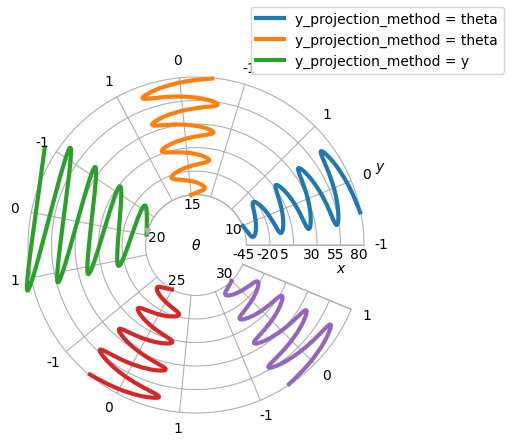

In [178]:
fig = lstein.draw(LSC)
fig.legend()
fig.show()